In [13]:
import torch
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.autograd import Variable

import pandas as pd
import numpy as np
import os

from tqdm import tqdm

from skimage import io as skio
from skimage import transform as sktr
from skimage import color as skco

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [40]:
cuda_device=4
batch_size=50

In [3]:
train = pd.read_csv('train_ready.csv')
val = pd.read_csv('valid_ready.csv')
test = pd.read_csv('test_ready.csv')

In [49]:
net = models.resnet50(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
num_ftrs = net.fc.in_features
net.fc = torch.nn.Sequential(torch.nn.Linear(num_ftrs, 100),
                             torch.nn.Dropout(),
                             torch.nn.LeakyReLU(),
                             torch.nn.Linear(100, 2))
net = net.cuda(cuda_device)
opt = optim.Adam(net.fc.parameters())

In [36]:
X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []

In [7]:
files = set(os.listdir('data'))

In [35]:
def get_image(path):
    return skco.gray2rgb(sktr.resize(skio.imread(path), (224, 224)))

In [37]:
for i in tqdm(range(train.shape[0])):
    if train.loc[i, 'filename'].split('\\')[-1] in files:
        X_train.append(get_image('data/' + train.loc[i, 'filename'].split('\\')[-1]))
        y_train.append(train.loc[i, 'label'])
        
for i in tqdm(range(val.shape[0])):
    if val.loc[i, 'filename'].split('\\')[-1] in files:
        X_val.append(get_image('data/' + val.loc[i, 'filename'].split('\\')[-1]))
        y_val.append(train.loc[i, 'label'])
        
for i in tqdm(range(test.shape[0])):
    if test.loc[i, 'filename'].split('\\')[-1] in files:
        X_test.append(get_image('data/' + test.loc[i, 'filename'].split('\\')[-1]))
        y_test.append(test.loc[i, 'label'])

  0%|          | 0/68527 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 17241/17241 [00:01<00:00, 9342.72it/s]


In [38]:
X_train = np.array(X_train).transpose([0, 3, 1, 2])
X_val = np.array(X_val).transpose([0, 3, 1, 2])
X_test = np.array(X_test).transpose([0, 3, 1, 2])
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [41]:
train_d = data_utils.TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
train_loader = data_utils.DataLoader(train_d, batch_size=batch_size, shuffle=True)

val_d = data_utils.TensorDataset(torch.Tensor(X_val), torch.LongTensor(y_val))
val_loader = data_utils.DataLoader(val_d, batch_size=batch_size, shuffle=True)

test_d = data_utils.TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))
test_loader = data_utils.DataLoader(test_d, batch_size=batch_size, shuffle=True)

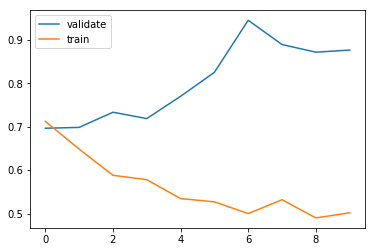

100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


In [50]:
n_epoch = 10
val_scores = []
train_scores = []
for epoch in tqdm(range(n_epoch)):
    
    val_loss = 0
    train_loss = 0
    i = 0
    net.train()
    
    for (x_batch, y_batch) in train_loader:
        x_batch = Variable(x_batch).cuda(cuda_device)
        y_batch = Variable(y_batch).cuda(cuda_device)
        loss = F.cross_entropy(net.forward(x_batch), y_batch).cuda(cuda_device)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.cpu().data.numpy()
        i += 1
    
    train_scores.append(train_loss / i)
    i = 0
    net.eval()
    
    for (x_batch, y_batch) in val_loader:
        x_batch = Variable(x_batch).cuda(cuda_device)
        y_batch = Variable(y_batch).cuda(cuda_device)
        loss = F.cross_entropy(net.forward(x_batch), y_batch).cuda(cuda_device)
        val_loss += loss.cpu().data.numpy()
        i += 1
    
    val_scores.append(val_loss / i)
    
    clear_output()
    plt.plot(val_scores, label='validate')
    plt.plot(train_scores, label='train')
    plt.legend()
    plt.xlabel='epoch'
    plt.ylabel='entropy score'
    plt.show()

In [51]:
loss = 0
for (x_batch, y_batch) in test_loader:
        x_batch = Variable(x_batch).cuda(cuda_device)
        y_batch = Variable(y_batch).cuda(cuda_device)
        pred = net.forward(x_batch).max(dim=1)[1]
        loss += (y_batch == pred).sum().cpu().data.numpy()

In [52]:
print(loss / X_test.shape[0])

[0.79487179]
